In [99]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

sys.path.append(os.path.abspath("/Users/evan/Documents/Projects/VsCode/Python/DSP"))
from DSP import transforms, domains

# Basic Signals and The Fast Fourier Transform

## A Simple Analog Signal

Before delving into the intricacies of adaptive filter frameworks, it is necessary to build some intuition concerning the notion of a signal. In general, a signal is presented in the time domain as a single tone or set of tones summed together. Mathematically, these are simply sinusoidal functions of time defined like 
$$
s(t) = A_1\sin(2\pi f_1 t) + A_2\sin(2\pi f_2 t) + \ldots + A_n\sin(2\pi f_n t).
$$
Here, $A_i$ represents the amplitude, the peak value, of each tone and $f_i$ represents the frequency, the oscillation rate, of each tone. In particular, the individual sinusoids are called "tones" because they oscillate at a fixed frequency $f_i$ and therefore are perfectly sinusoidal. In practical settings, a tone, for instance the tone generated by humming a single note, can never be entirely fixed in frequency. Instead, its true frequency will tilt to either side of the nominal frequency.

Moreover, notice that the argument of each sine function is a coefficient $2\pi f_i$ scaled by the parameter $t$. This is merely a definition for the angular frequency of oscillations. Namely, 
$$
\omega = 2\pi f.
$$
Indeed, we expect the argument of sine to be an angle. In this case, the angle $\theta(t)$ is parameterized like 
$$
\theta(t) = \omega t = 2\pi f t.
$$

All in all, as time progresses by an amount $\Delta t$, an angle $\Delta\omega = 2\pi f\Delta t$ is swept through. Increasing $f$ scales the width of the angular sweep over the same time interval $\Delta t$. This justifies the well-known choice of units for frequency: $\frac{\text{cycles}}{\text{sec.}}$.

With that in mind, consider a linear combination of 3 distinct tones. These will make up the signal $s(t)$ defined below.

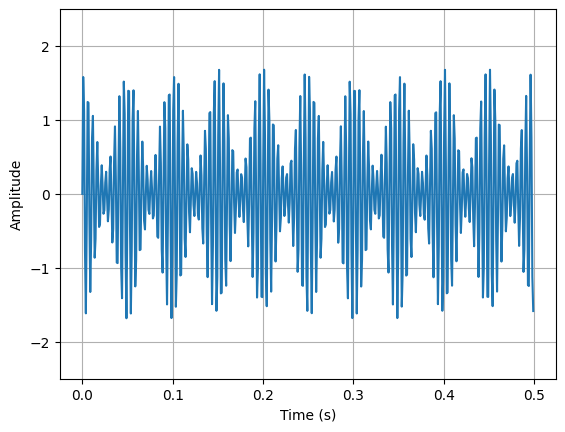

In [100]:
fs = 1024                   # Sampling rate                   
L = 512                     # Number of samples                       
tones = [180, 200, 220]     # Frequencies in Hz
amps = [0.5, 1, 0.2]        # Tone amplitudes
noise_coefficient = 0.001   # Gaussian noise scale

t = domains.times(fs, L)
s = domains.generate_signal(L, tones, amps, noise_coefficient, t)

plt.plot(t, s)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-2.5, 2.5)
plt.grid()
plt.show()


Notice that the compound signal generates a beating phenomenon, where the amplitude of the signal, or its envelope, periodically peaks. This behavior is reminiscent of amplitude modulation, where a single carrier frequency $f_0$ supports an envelope that itself oscillates with some message signal $m(t)$. The connection between the two lies in the trigonometric sum-to-product identities. For example, given a signal characterized by the sum of two cosine tones, their function representation can be rewritten like
$$
A_1\cos(\omega_1 t) + A_2\cos(\omega_2 t) = 2A_1A_2\cos\left(\frac{\omega_1+\omega_2}{2}t\right)\cos\left(\frac{\omega_1-\omega_2}{2}t\right).
$$ 
Indeed, the equivalent representation suggests that the signal is really a carrier tone at the average frequency $\frac{\omega_1 + \omega_2}{2}$ multiplied by a message tone at the difference frequency $\frac{\omega_1 - \omega_2}{2}$.



## Sampling and Discrete Signals

Furthermore, take special note of the two quantities $N$ and $f_s$: the number of samples and the sampling rate. Together they enable a transformation from the time-continuous signal to a time-discrete representation. 

The reality is, no physical signal can be observed continuously over an infinite interval. That is, unless a well-behaved, well-defined function existed for every possible arbitrary signal, there is no way to actually quantify those signals continuously. Instead, it must be discretely sampled $N$ times at a  sampling rate $f_s$ (samples per second). So, for a set of sampling indices
$$
I = \{0, 1, 2, \ldots, N - 1\},
$$
and a sampling rate $f_s$, the discrete set of time indices, the instants in time, is given by
$$
t_i = \frac{i}{f_s}\quad (i \in I) \implies T = \left\{0,\, \frac{1}{f_s},\, \frac{2}{f_s},\, \ldots,\, \frac{N-1}{f_s}\right\}.
$$
Alternatively, recalling that the period $T$ of a signal is given by the reciprocal of the frequency $\frac{1}{f}$, the same result can be written in a more illuminating fashion as
$$
t_i = iT_s\quad (i \in I) \implies T =  \{0,\, T_s,\, 2T_s,\, \ldots,\, (N-1)T_s\}.
$$
In particular, the time-discrete domain over which the sampled signal is defined is just a set of time inputs equally spaced by the sampling period $T_s$. Therefore, the discrete signal values for a pure tone become 
$$
s_i = A_1\sin\left(2\pi f t_i\right) = A_1\sin\left(2\pi \frac{f}{f_s}i\right).
$$
Additionally, notice that the total record length of the signal is 
$$
t_{\text{final}} = \frac{N}{f_s}.
$$

## Challenges Posed by Time-Domain Analysis

So far, we've considered very uniform signals with distinct and tangible frequency components, and even they demonstrated holistic behavior that differed from the behavior of their individual components. However, a genuine signal can span several frequency bands, contain many different frequencies, and be riddled with noise or distortion. For instance, consider the following two signals:

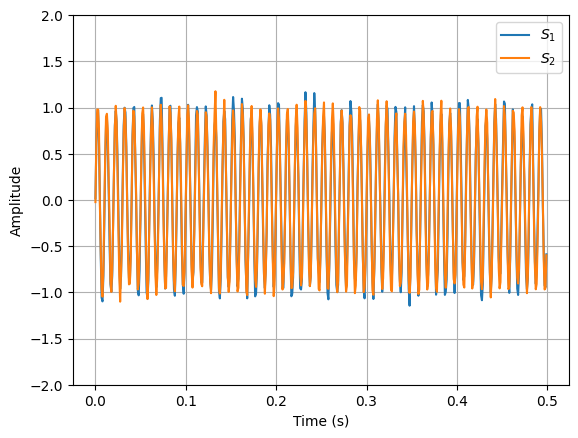

In [101]:
tones1 = [100, 1000]
amps1 = [1, 0.1]
tones2 = [100]
amps2 = [1]
noise_coefficient1 = 0.05   

s1 = domains.generate_signal(L, tones1, amps1, noise_coefficient1, t)
s2 = domains.generate_signal(L, tones2, amps2, noise_coefficient1, t)

plt.plot(t, s1, label='$S_1$')
plt.plot(t, s2, label='$S_2$')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-2, 2)
plt.legend()
plt.grid()
plt.show()

Evidently, just eyeballing these two signals may not be enough to distinguish one from the other. Yet, $S_1$ possesses a weak high-frequency buzz that is not immediately obvious, especially with the addition of noise. This is a simplified example, but imagine a signal containing several other low-frequency, high-amplitude components alongside a buzz sitting up in the Ghz range. There would be no way of knowing the true makeup of that signal, permitting one to ask: "Is there an easier way for us to unscramble a signal into its constituent components?" 

## Enter the Fourier Transform

Ideally, we would like to be able to somehow dissect the signal into its individual tones and observe them one at a time. That way, it becomes a simple process of reading off each frequency and amplitude. Well, in principle, this is exactly the function of the Discrete Fourier Transform.

### Definition
For a discrete signal $x[n]$, its DFT $X[k]$ is defined as 
$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi k\frac{n}{N}},\quad k = 0, \ldots, N - 1
$$

The resulting data encodes a frequency spectrum that peaks at the particular frequencies embedded within the original signal, where the height of those peaks correspond to the amplitude of the associated tone. But before we can see this powerful tool in action, it is vital to gain some intuition for how the DFT distinguishes frequencies from one another in an otherwise confounding signal. Consider these two perspectives.

### Scaling the Roots of Unity
Notice that all the DFT is doing is summing over all N products of a time-domain sample $s[n]$ and a complex phase $e^{-j2\pi k\frac{n}{N}}$. Looking closely, these complex phases represent the vertices of a regular $N$-gon on the complex unit circle. In general,
$$
W_N = e^{-j2\pi/N}
$$
are the $N$ th roots of unity, where 
$$
W_N^{kn} = e^{-j2\pi k\frac{n}{N}}
$$
is the $n$ th root scaled by an amount $k$. To see this more clearly, observe the following figure.

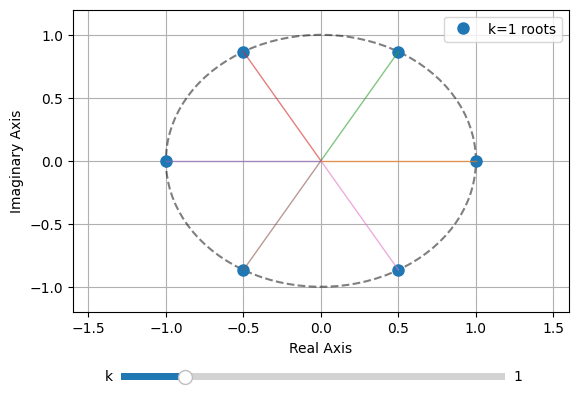

In [102]:
N = 6
k0 = 1
def compute_roots(k):
    return np.exp(2j*np.pi*k*np.arange(N) / N)

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

circle_theta = np.linspace(0, 2*np.pi, 100)
unit_circle, = ax.plot(np.cos(circle_theta), np.sin(circle_theta), 'k--', alpha=0.5)

roots = compute_roots(k0)
roots_scatter = ax.plot(roots.real, roots.imag, 'o', markersize=8, label=f'k={k0} roots')[0]

lines = []
for r in roots:
    line, = ax.plot([0, r.real] , [0, r.imag], linewidth=1, alpha=0.6)
    lines.append(line)

plt.xlim(-1.6, 1.6)
plt.ylim(-1.2, 1.2)
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.legend()
plt.grid()

ax_k = plt.axes([0.2, 0.1, 0.6, 0.03])
slider_k = Slider(ax=ax_k, label='k', valmin=0, valmax=6, valinit=k0, valstep=1)

def update(val):
    k = slider_k.val
    new_roots = compute_roots(k)

    roots_scatter.set_xdata(new_roots.real)
    roots_scatter.set_ydata(new_roots.imag)

    for line, r in zip(lines, new_roots):
        line.set_xdata([0, r.real])
        line.set_ydata([0, r.imag])
    fig.canvas.draw_idle()

slider_k.on_changed(update)
plt.show()


More specifically, each sequence of roots $\left\{W_N^{kn}\right\}_{n=0}^{N-1}$ is an $N$ sampled complex exponential tone at the discrete frequency index $k$. That is, the sequence of complex phases is just a complex pure tone. Scaling the phase by $k$ is effectively identical to scaling by a frequency - namely, encoding how many samples can "fit" in a single period.

Moreover, the DFT takes the $k$ th pure tone and samplewise multiplies (scales) it by the input signal. It then sums over all those products, which, in the complex plane, corresponds to a kind of phase-preserving vector addition. In other words, the DFT asks "how much of tone $k$ is in x[n]?" and performs a scaling of the tone's components by the value of $x[n]$. If $x[n]$ closely matches the phase and frequency of the given exponential, the products add coherently and present a large magnitude. If instead $x[n]$ is orthogonal or contains very little of the exponential's frequency, the products cancel out leading to a small magnitude.

### Projecting into Frequency-Space

Alternatively, consider the space $\mathbb{C}^N$ of all length-N complex vectors. We can define an inner product
$$
\langle x, y\rangle = \sum_{n=0}^{N-1}x[n]\overline{y[n]}
$$
over this space. Hence, $\mathbb{C}^N$ is an $N$ -dimensional inner-product space, and therefore any member set of mutually orthonormal vectors must form a basis. Indeed,
$$
\left\{\phi_k[n] = \frac{1}{\sqrt{N}}e^{j2\pi k n/N}\right\}_{k = 0}^{N-1}
$$
is an orthonormal basis of $\mathbb{C}^N$. We can check this by computing the inner product of any two members of this basis set. We have,
$$
\langle \phi_k, \phi_l, \rangle = \frac{1}{N}\sum_ne^{j2\pi k n/N}e^{-j2\pi l n/N} = \frac{1}{N}\sum_ne^{j2\pi (k - l) n/N} = \delta_{kl},
$$
where the kronecker delta $\delta_{kl}$ is 1 when $k = l$ and 0 otherwise.

So, each unique set of phasors for a given $k$, really the set of pure tones at the $k$ th frequency, represents a basis in $\mathbb{C}^N$, and we want to know by how much $x[n]$ points along the unit-length basis vector $\phi_k$. Recalling even the earliest principles of linear algebra, we can determine exactly how much one vector points along another by taking their inner product. Hence, we need only compute
$$
\langle x, \phi_k \rangle = \sum_{n=0}^{N-1}x[n]\frac{1}{\sqrt{N}}e^{-j2\pi k n/N} = \frac{X[k]}{\sqrt{N}}.
$$
This is exactly the DFT, up to a normalization. This also justifies the use of the conjugate phase (the negative exponential) given the sesquilinear definition of the inner product.

## Constraints on DFT Length, Domain Resolution, and Frequency Span

### $N_{fft}$

Before finally transforming our data, another important parameter needs to be discussed: $N_{fft}$, the effective length of the DFT. To make clear its relevance, recall that an $N$ -sampled complex phasor representing a tone at the $k$ th frequency looks, in general, like
$$
\phi_k = e^{-j2\pi f_kt_n} = e^{-j2\pi f_knT_s} = e^{-j2\pi f_k\frac{n}{f_s}}.
$$
Note that any signal is the real part of a linear combination of these phasors. If we then choose 
$$
f_k = \frac{k}{NT_s} = \frac{kf_s}{N},
$$
we arrive at our familiar basis phasor
$$
\phi_k = e^{-j2\pi \frac{kn}{N}}.
$$
Because this unifying choice for $f_k$ stems directly from the very definition of the DFT, specifically the canonical basis, it suggests that the sampling length $N$ ought to be common to the two domains. In fact, because those basis phasors presume exactly $N$ time samples to satisfy the pointwise multiplication criterion, the DFT should require $N_{fft}\leq N$ in practice. Still, anything less than $N$ simply skips out on information since fewer comparisons with $x[n]$ are made. 

### Domain Resolution

This highlights the issue of resolution. In particular, notice that the number of samples $N$ directly impacts the width of the $k$ th frequency snapshot, otherwise known as the frequency bin. That is, each frequency sample occurs in intervals of
$$
\Delta f = \frac{f_s}{N},
$$
thus specifying the fineness of the DFT. On the other hand, recall each time sample occurs in intervals of
$$
\Delta t = \frac{1}{f_s},
$$
specifying the fineness of the time-series. It follows that
$$
\Delta f \Delta t = \frac{1}{N}.
$$
This is our constraint on the fineness or resolution of the signal in either domain for $N$ samples. Note that for a fixed number of samples $N$, a finer time spacing, namely a higher sampling rate $f_s$, necessarily makes the frequency bins coarser.

### Frequency Span

Moreover, we can also constrain $k$ by noticing that
$$
\phi_{N_{fft}} = e^{-j2\pi N_{fft}\frac{n}{N_{fft}}} = e^{-j2\pi n} = 1 = \phi_0.
$$
Thus, our discrete-time Fourier basis is $N_{fft}$ -periodic and so $k$ need only span 0 through $N_{fft} -1$. One way to understand this is to recall that the $k$ th frequency bin, constrained by our definition
$$
f_k = \frac{k}{N}f_s,
$$
is proportional to $f_s$ by a factor of exactly the ratio of $k$ to $N$. Hence, for a fixed time resolution, and thus a fixed $f_s$, the resulting frequency resolution $\Delta f = \frac{f_s}{N} = \frac{\text{const.}}{N}$ demands precisely $N$ frequency bins. Asking for more than $N$ bins amounts to exceeding the degree of information provided by the above constraint on the frequency grid resolution. This should be intuitive since we expect the dimension of a vector or function to remain unchanged under a linear map.

An important consequence of this is that the sampling rate $f_s$ constrains the range of frequencies that can binned. To wit, termination at the sample corresponding to $k = N_{fft}$ directly implies $f_k = f_s$. This can only mean that the sampling rate is responsible for determining the span of the frequency spectrum. 

To conceptualize this, suppose a time-domain signal is sampled at rate of 1000 Hz but contains a signal whose frequency is 2000 Hz. One can imagine that as the signal is sampled, it will swing through two full periods between successive samples, leaving behind information about that in-between oscillation. This is to say that the signal's 2000 Hz component will, at best, masquerade as an $f_s = 1000$ Hz component in the DFT.

With these key ideas out of the way, let's have a look at our transformed three-tone signal.

## DFT Examples and Implementation

Now that we've developed a feeling for how the DFT takes a signal in the time domain and reconstructs it in the frequency domain, let's revisit that three-tone signal we introduced at the very beginning. Supposing we knew nothing about it in advance, we can gain some insight into what's really going on by observing that signal's frequency representation through a DFT. 

We might begin with a simple brute-force approach: directly computing the DFT as a looped summation.

In [103]:
def DFT(x, nfft):
    """
    Direct O(N^2) implementation of the DFT.
    """
    X = np.zeros(nfft, dtype=complex)
    # DFT
    for k in range(nfft):
        acc = 0+0j
        for n in range(nfft):
            acc += x[n] * np.exp(-2j * np.pi * k * n / nfft)
        X[k] = acc
    return X

Notice that this function directly computes each inner product and appends the sum to the output array. This is a pure implementation of the mathematical model. Evidently, its time complexity is $O(N^2)$, where $N = N_{fft}$.

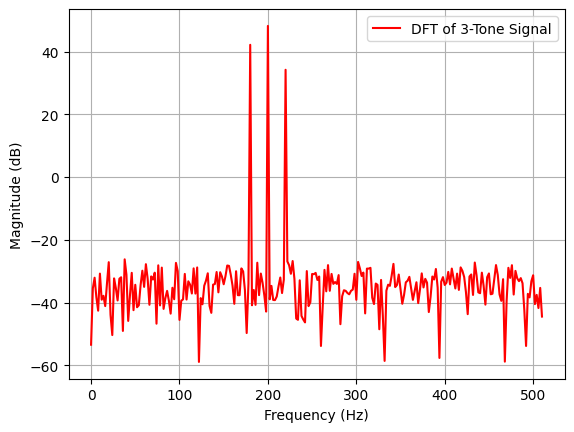

In [104]:
nfft = 512
freqs = np.arange(nfft) * (fs / nfft)   # f_k = k*f_s / nfft
freqs = freqs[:nfft//2]

dft = DFT(s, nfft)
mags_db = 20*np.log10(np.abs(dft[:nfft//2]) + 1e-12)

plt.plot(freqs, mags_db, label='DFT of 3-Tone Signal', color ='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.show()

Lo and behold, our spectrum prominently features three distinct peaks at those very component frequencies that comprise our signal. Notice that they each also reflect the relative amplitude of their associated tone. The scale, however, is logarithmic, so their peak values are not proportioned evenly. This is a common approach when plotting the frequency spectrum.

Additionally, we see a long band of noise spanning the entire spectrum sitting at around -37 dB. This is known as the noise floor and represents the ambient noise or unwanted signal present in the system. In this example, the noise is entirely synthetic, but expect to see this characteristic behavior in all spectra. 

It is important to point out that while the DFT returns a complex function, the frequency spectrum is a magnitude plot. This aligns with our previous understanding that the DFT indicates the magnitude with which a signal points along a given basis tone. Nonetheless, phase is also preserved, as mentioned earlier, and its utility is not to be ignored in the further discussion. 

Now, this example was not very illuminating from an analysis standpoint, especially because we already know what frequency components our signal contains. In fact, it's unlikely that such a clean-cut and uniform signal exists in practice, so let's consider another example: a tone that is clipped above and below to resemble a square wave.

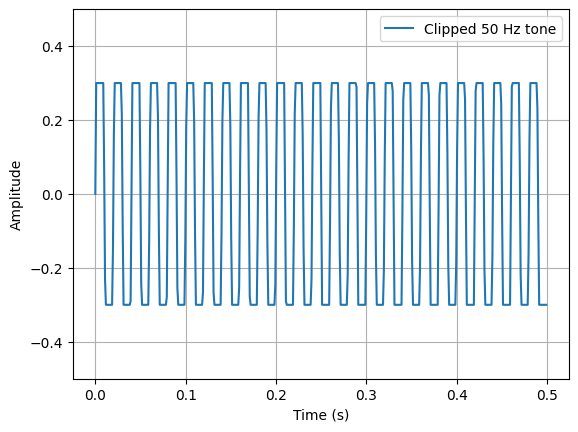

In [105]:
f1 = 50
t1 = domains.times(fs, L)
threshold1 = 0.3

tone1 = np.sin(2*np.pi*f1*t1)
clipped_tone1 = np.clip(tone1, -threshold1, threshold1)

plt.plot(t1, clipped_tone1, label='Clipped 50 Hz tone')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-.5, .5)
plt.grid()
plt.legend()
plt.show()


Now we take the DFT.

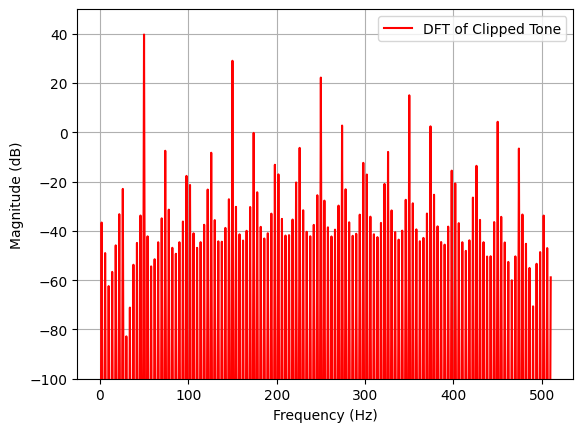

In [106]:
freqs1 = np.arange(nfft) * (fs / nfft)
freqs1 = freqs1[:nfft//2]

dft1 = DFT(clipped_tone1, nfft)
mags_db1 = 20*np.log10(np.abs(dft1[:nfft//2]) + 1e-12)

plt.plot(freqs1, mags_db1, label='DFT of Clipped Tone', color='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim(-100, 50)
plt.grid()
plt.legend()
plt.show()

Now our spectrum is decidedly more interesting. What presumably stands out the most is this grass-like pedestal between the primary spikes. Without going into too much detail now, this is a result of spectral leakage, where energy from the fundamental peaks shows up in nearby frequency bins. This is a result of the signal's imperfect periodicity leading to frequency components never consistently lining up with with the DFT's basis or probing tones. 

Additionally, it might seem at first odd that, while our 50 Hz peak shows up where expected, we see additional peaks of decreasing magnitude show up in the spectrum. What's more, these peaks appear evenly spaced at odd multiples of the fundamental frequency (150 Hz, 250 Hz, etc.)

Again, not straying too far from the subject, we can represent the approximately square waveform as a Fourier series. Namely, 
$$
s(t) = \frac{4}{\pi}\sum_{n=1,2,3,\ldots}\frac{1}{n}\sin\left(\frac{n\pi t}{L}\right),
$$
where $L$ is the half-period length. Now, this expansion seeks to approximate a perfect step function, but it nonetheless demonstrates that a square wave can be decomposed into a sum of distinct tones at odd multiples of the fundamental frequency. Those tones beyond the first fundamental are called harmonics. Moreover, each subsequent tone decays in amplitude by a factor of $\frac{1}{n}$. So, in fact, the spectral decomposition is exactly in line with our expectation, save for the spectral leakage.

Once again, without the DFT, that single-frequency, clipped signal is almost impossible to truly interpret. Indeed, the ability to observe these harmonics represents just one more of the many advantages of Fourier analysis.

## Stronger Algorithms - The Fast Fourier Transform

With the general analysis concluded, we can begin to think about cleverer and, more importantly, faster implementations of the DFT. Straight away, one might have noticed that in the brute-force implementation, we seem to be computing the basis phasors, what we shall henceforth call the "twiddle factor," on each DFT pass. This can be avoided by precomputing the set, something we can do thanks to $N_{fft}$ being fixed.

In [107]:
def DFT(x, nfft=None):
    """
    Direct O(N^2) implementation of the DFT.
    """
    x = x.astype(complex)
    N0 = len(x)

    nfft = N0 if nfft is None else nfft
    pad_amt = nfft - N0

    # Pad or truncate the signal
    if nfft < N0:
        x = x[:nfft]
    elif nfft > N0:
        x = np.concatenate([x, np.zeros(pad_amt, dtype=complex)])
        
    #  Precomputed twiddle
    twiddle = np.exp(-2j * np.pi / nfft)

    # DFT
    X = np.zeros(nfft, dtype=complex)
    for k in range(nfft):
        acc = 0+0j
        for n in range(nfft):
            acc += x[n] * twiddle**(k*n)
        X[k] = acc
    return X

This works well enough, but it doesn't exactly get to the heart of the problem.

### Cooley-Tukey FFT

As we've already seen, eliminating redundancy is crucial to minimizing computation, and a particularly important and, now very common, approach is to divide-and-conquer so as to reuse previous results. That is, assign separate halves of the problem to a distinct but identical operations and then recombine them in such a way that shares the results of each half.

Consider splitting the DFT, given by
$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi k\frac{n}{N}},
$$
into its even and odd sums. This is simply a matter of relabeling the even indices $n = 2m$ and the odd indices $n = 2m+1$. Then,
$$
X[k] = \sum_{m=0}^{N/2-1}x[2m]e^{-j2\pi k\frac{2m}{N}} + \sum_{m=0}^{N/2-1}x[2m + 1]e^{-j2\pi k\frac{2m+1}{N}}.
$$
We can then preserve the symmetry of the definition by factoring out an exponential in the second term, leaving 
$$
X[k] = \sum_{m=0}^{N/2-1}x[2m]e^{-j2\pi k\frac{2m}{N}} + e^{-\frac{j2\pi k}{N}}\sum_{m=0}^{N/2-1}x[2m + 1]e^{-j2\pi k\frac{2m}{N}} = E[k] + e^{-\frac{j2\pi k}{N}}O[k],\quad k = 0, \ldots, \frac{N}{2}-1.
$$
Notice, however, that we have lost half of our frequency bins in this process. Fortunately, we can leverage periodicity once again and obtain
$$
\begin{aligned}
X\left[k + \frac{N}{2}\right] =&\; \sum_{m=0}^{N/2-1}x[2m]e^{-j2\pi \left(k + \frac{N}{2}\right)\frac{m}{N/2}} + e^{-\frac{j2\pi \left(k + \frac{N}{2}\right)}{N}}\sum_{m=0}^{N/2-1}x[2m + 1]e^{-j2\pi \left(k + \frac{N}{2}\right)\frac{m}{N/2}} \\
=&\; \sum_{m=0}^{N/2-1}x[2m]e^{-j2\pi k\frac{m}{N/2}}e^{-j2\pi m} + e^{-\frac{j2\pi k}{N}}e^{-j\pi}\sum_{m=0}^{N/2-1}x[2m + 1]e^{-j2\pi k\frac{2m}{N}}e^{-j2\pi m} \\
=&\; \sum_{m=0}^{N/2-1}x[2m]e^{-j2\pi k\frac{m}{N/2}} - e^{-\frac{j2\pi k}{N}}\sum_{m=0}^{N/2-1}x[2m + 1]e^{-j2\pi k\frac{2m}{N}} \\
=&\; E[k] - e^{-\frac{j2\pi k}{N}}O[k],\quad k = 0, \ldots, \frac{N}{2}-1.
\end{aligned}
$$
Hence,
$$
\begin{cases}
X[k] &= E[k] + e^{-\frac{j2\pi k}{N}}O[k] \\
X\left[k + \frac{N}{2}\right] &= E[k] - e^{-\frac{j2\pi k}{N}}O[k]
\end{cases}
,\quad k = 0, \ldots, \frac{N}{2}-1.
$$

Straight away we can spot the shrewdness of this restructuring: The same $E[k]$ and $O[k]$ feed both half-spectrum outputs. Specifically, we need only compute the two half-length DFTs once, along with the twiddle factor, to get two half-length outputs. This means that instead of computing $N$ DFT products for each of the $N$ frequencies, we simply compute $N/2$ products for two half sets of $N/2$ frequencies and merge them at the cost of an extra twiddle factor computation.

From a time complexity standpoint, the brute force DFT requires $N \times N = N^2$ computations. Whereas, splitting up the work leaves us with two DFTs each requiring just $\frac{N}{2} \times \frac{N}{2} = \frac{N^2}{4}$ computations. Then, to merge them together costs $N$ operations. So, overall, $2 \times \frac{N^2}{4} + N$ operations.

Of course, nothing prevents us from continuously splitting up the work until each delegate DFT is just a trivial computation. The following implementation takes advantage of this by recursively calling upon the divide-and-conquer methodology.

In [129]:
def naive_CT(x, nfft=None):
    """
    Recursive radix-2 FFT (divide & conquer) with O(N log N) complexity.
    """
    x = x.astype(complex)
    N0 = len(x)

    nfft = N0 if nfft is None else nfft
    nfft = 1 << (nfft-1).bit_length()    # next pow2 >= nfft
    pad_amt = nfft - N0

   # Pad or truncate the signal
    if nfft < N0:
        X = x[:nfft]
    elif nfft > N0:
        X = np.concatenate([x, np.zeros(pad_amt, dtype=complex)])
    else:
        X = x
    
    # Even-Odd recursive DFTs
    tw = np.exp(-2j * np.pi * np.arange(nfft) / nfft)
    # Base Case
    if nfft == 1:
        return np.array(X, dtype=complex)
    # Butterfly stages
    even = naive_CT(X[::2])
    odd  = naive_CT(X[1::2])
    X = np.zeros(nfft, dtype=complex)
    for k in range(nfft//2):
        X[k]       = even[k] + tw[k] * odd[k]
        X[k+nfft//2]  = even[k] - tw[k] * odd[k]
    return X

Clearly, after evenly dividing the signal $\log_2(N)$ times, the original singular DFT becomes $N$ single-sample DFTs, each of which requires just one trivial operation across the $N/2$ (total) frequencies. In fact, realize that the base case DFT reduces to
$$
X[0] = \sum_{n=0}^{0}x[n]e^{-j2\pi \frac{0\cdot n}{N}} = x[0]\cdot 1.
$$
As it turns out, a rather beautiful consequence of $N$ -dividing the original signal is that the DFT vanishes. In truth, we've carried over the encoding of the phase information into the merge step, but it still feels somewhat magical. This process of combining the broken-down information is called a butterfly operation.

Notice that we also take care to restrict $N_{fft}$ to powers of 2. This way, the signal can be divided evenly right up until the unit arrays. If the number of times samples is not itself a power of 2, the signal is padded with zeros until its length equals the nearest larger power of 2. The same occurs if the passed value for $N_{fft}$ is not a power of 2 either. In general, it is best to just chose a power of 2 for the number of fft samples.

### In-Place Decimation-in-Time Cooley-Tukey FFT

In terms of time-complexity, outside of shaving off constant factors, the above algorithm is as good as it gets for simple multiplications and additions. Instead, one last measure we might take to reduce space complexity is to attempt an in-place FFT, removing the need for temporary storage buffers.

This process hinges on the idea of bit-reversal: exchanging each element at index $i$ with the element at the index whose value is $i$'s binary representation reversed. To see why this is powerful, consider what happens to the input signal array as it is recursively divided in two. We begin with a length $N$ array and split it into two blocks of size $L = \frac{N}{2}$, separating even from odd indices. We do this over and over, a total of $m = \log_2(N)$ times, until what remains are $\frac{N}{2}$ blocks of size $L = 2$ (the size 1 blocks are trivial). From this point, the butterfly merging may begin. Let's index the first stage with $s = 0$ and label the size of each block in stage $s$ as $L = 2^{s + 1}$, where the half-size of each block is naturally $\frac{L}{2} = 2^s$. 

Now, in general, to merge two halves in a given stage, we pair the $k$ th element of the first half with the $k$ the element of the second half, since we are trying to pair an even index element with its associated odd index element. In linear memory, those two elements are exactly $2^s$ apart, because that second half start $2^s$ indices after the first. Specifically, 
$$
(i + k)\quad \text{pairs with}\quad (i + k + 2^s).
$$
The trick to this is that by bit-reversing up front, that is, permuting the input into bit-reversed order, each of these blocks of size $L$ becomes contiguous. Namely, the elements at those indices separated by a distance of $2^s$ become consecutive. It's hard to see at first why this works, but observe this small example.
$$
N = 8\\
\begin{array}{c c c c}
\hline
n & \text{binary} & \text{reversed} & \text{decimal} \\
\hline
0 & 000 & 000 & 0 \\
1 & 001 & 100 & 4 \\
2 & 010 & 010 & 2 \\
3 & 011 & 110 & 6 \\
4 & 100 & 001 & 1 \\
5 & 101 & 101 & 5 \\
6 & 110 & 011 & 3 \\
7 & 111 & 111 & 7 \\
\hline
\end{array}
$$
Notice how each of the consecutive pairs of indices are exactly $2^s = \frac{L}{2} = 4$ apart. If we then start dividing by parity: $$(0, 2, 1, 3);\quad (4, 6, 5, 7) \rightarrow (0, 1);\quad (2, 3); \quad (4, 5); \quad (6, 7).$$
The stage 0 butterfly is suddenly in order. Specifically, paired elements have their indices spaced $2^s = 2^0 =1$ apart, but the premise is obvious now. Any subsequent stages require merging elements at an index spacing of $2^s$. Additionally, every index participates in exactly one butterfly per stage, and as each pair is used up, those very two slots are replaced by the merged results, ensuring no data is lost in the process.

Below is the implementation.

In [124]:
def bit_reverse(n, m):
    r = 0
    for _ in range(m):
        r = (r << 1) | (n & 1)
        n >>= 1
    return r

def radix2_fft(x, nfft=None):
    """
    In-place radix-2 decimation-in-time FFT. x is modified and returned.
    """
    x = x.astype(complex)
    N0 = len(x)

    nfft = N0 if nfft is None else nfft
    nfft = 1 << (nfft-1).bit_length()    # next pow2 >= N0
    pad_amt = nfft - N0

   # Pad or truncate the signal
    if nfft < N0:
        X = x[:nfft]
    elif nfft > N0:
        X = np.concatenate([x, np.zeros(pad_amt, dtype=complex)])
    else:
        X = x
    
    m = int(np.log2(nfft))     # Max bit length
    # Bit-reversal permutation
    for n in range(nfft):
        r = bit_reverse(n, m)
        if r > n:
            X[n], X[r] = X[r], X[n]
    # Butterfly stages
    half = 1
    for stage in range(m):
        L = half * 2
        W = np.exp(-2j * np.pi * np.arange(half) / L)
        for start in range(0, nfft, L):
            for k in range(half):
                a = X[start + k]
                b = X[start + k + half] * W[k]
                X[start + k]        = a + b
                X[start + k + half] = a - b
        half = L
    return X

Appreciate how, by presupposing the order in which elements are divided, we can fully avoid recursion by already knowing the location of all the pairs. This eliminates the need for a buffer at each stage to hold the merged set.

## Time-Complexity Comparison

Below is a simple loglog comparison of the naive DFT and the more robust FFT. Notice that at around $N = 10^1 + 6 = 16$, the runtimes begin to diverge. Keep in mind also that Python is, of course, an interpreted language and therefore suffers from interpretive overhead in the overall computation. A compiled language implementation, as we will later see, reduces the overall computation time significantly.

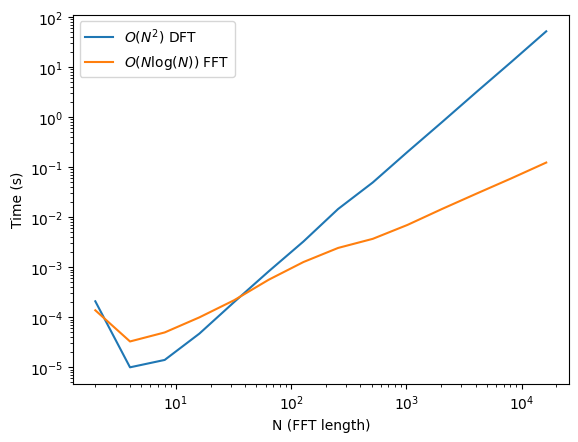

In [149]:
import time

N = 15
nffts = [2**n for n in range(1, N)]
DFT_times, FFT_times = [], []

for nfft in nffts:
    start_time = time.time()
    result = DFT(s, nfft)
    end_time = time.time()

    elapsed_time = end_time - start_time
    DFT_times.append(elapsed_time)

    start_time = time.time()
    result = naive_CT(s, nfft)
    end_time = time.time()

    elapsed_time = end_time - start_time
    FFT_times.append(elapsed_time)

plt.loglog(nffts, DFT_times, label='$O(N^2)$ DFT')
plt.loglog(nffts, FFT_times, label='$O(N \log(N))$ FFT')
plt.xlabel('N (FFT length)')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

## Key Takeaways

### DFT as Inner-Product Projections

 We saw that the DFT really just computes the inner products of our signal with a set of orthogonal complex exponentials. Each set of phasors represents a discretely sampled tone at a fixed frequency, so the DFT is really computing the degree with which our signal aligns with each of those complex tones - one coefficient per time-sample degree of freedom.

### $N$-point Transformation $\implies$ $N$ frequency Bins

Because our time-window has N samples, the spectrum's grid spacing $\Delta f = f_s/N$ gives exactly N independent bins. Any additional bins simply roll over to the next identical period. Further, each inner product is at most of length $N$ since, for any inner product, the dimension of the two vectors must match (padding and truncating are options too).

### Computational Leap via Cooley-Tukey FFT Algorithm

By factoring the big $O(N^2)$ sum int two $N/2$ -point DFTs plus the "twiddle" recombination, the cost of computation can be recursively driven down to $O(N \log(N))$.

### In-place radix-2 FFT

An initial bit-reversed permutation of the data allows the $\log_2(N)$ divisions to be predictably indexed into. The butterfly stages then require just in-place memory access without the need for buffers.



With these foundational principles in place, and a solid FFT algorithm to analyze with, we can turn our attention to how real-world signals deviate from ideal models. In particular, windowing will help us manage challenges like spectral leakage and and artifacting. 